In [1]:
import inspect
import os
import numpy as np

from tensorflow.keras.models import load_model
from segmentation_models.training.loss_functions import dice_coef_loss, tversky_loss
from segmentation_models.dataset.load_dataset import load_10_validation_files, load_100_validation_files
from segmentation_models.utils.utils_functions import show_images, noise_image
from shapley_analyzer.shapley import calculate_shapely_for_model
from tensorflow.keras.optimizers import Adam
from shapley_analyzer.prepare_input_data import convert_map_to_arrays
import matplotlib.pyplot as plt

PATH = os.path.dirname(os.path.dirname(os.path.abspath(inspect.stack()[0][1])))

In [2]:
# Load all trained models

filename = os.path.join(PATH, 'segmentation_models', 'trained_models','fcn_dice.h5' )
fcn_dice_model = load_model(filename, compile=False)
fcn_dice_model.compile(optimizer=Adam(learning_rate = 0.0001), loss=[dice_coef_loss], metrics=['accuracy'])

filename = os.path.join(PATH, 'segmentation_models', 'trained_models','fcn_tversky.h5' )
fcn_tversky_model = load_model(filename, compile=False)
fcn_tversky_model.compile(optimizer=Adam(learning_rate = 0.0001), loss=[tversky_loss], metrics=['accuracy'])

filename = os.path.join(PATH, 'segmentation_models', 'trained_models','unet_dice.h5' )
unet_dice_model = load_model(filename, compile=False)
unet_dice_model.compile(optimizer=Adam(learning_rate = 0.0001), loss=[dice_coef_loss],
                    metrics=['accuracy'])

filename = os.path.join(PATH, 'segmentation_models', 'trained_models','unet_tversky.h5' )
unet_tversky_model = load_model(filename, compile=False)
unet_tversky_model.compile(optimizer=Adam(learning_rate = 0.0001), loss=[tversky_loss], metrics=['accuracy'])

models = [ fcn_dice_model, fcn_tversky_model, unet_dice_model, unet_tversky_model]
model_names = ['FCN(dice loss)', 'FCN(tversky loss)', 'UNET(dice loss)', 'UNET(tversky loss)']

In [3]:
# Load validation data set

x_validate, y_validate = load_10_validation_files()

In [4]:
# Compute shapley value for all models

shapely, accuracy = {}, {}
feature_names = ['red', 'green', 'blue']
for model in enumerate(models):
    shapely[model_names[model[0]]], accuracy[model_names[model[0]]]= calculate_shapely_for_model(feature_names, x_validate, y_validate, model[1], feature_type='image')

1/1 [==============================] - 1s 896ms/step - loss: 0.9137 - accuracy: 0.9674


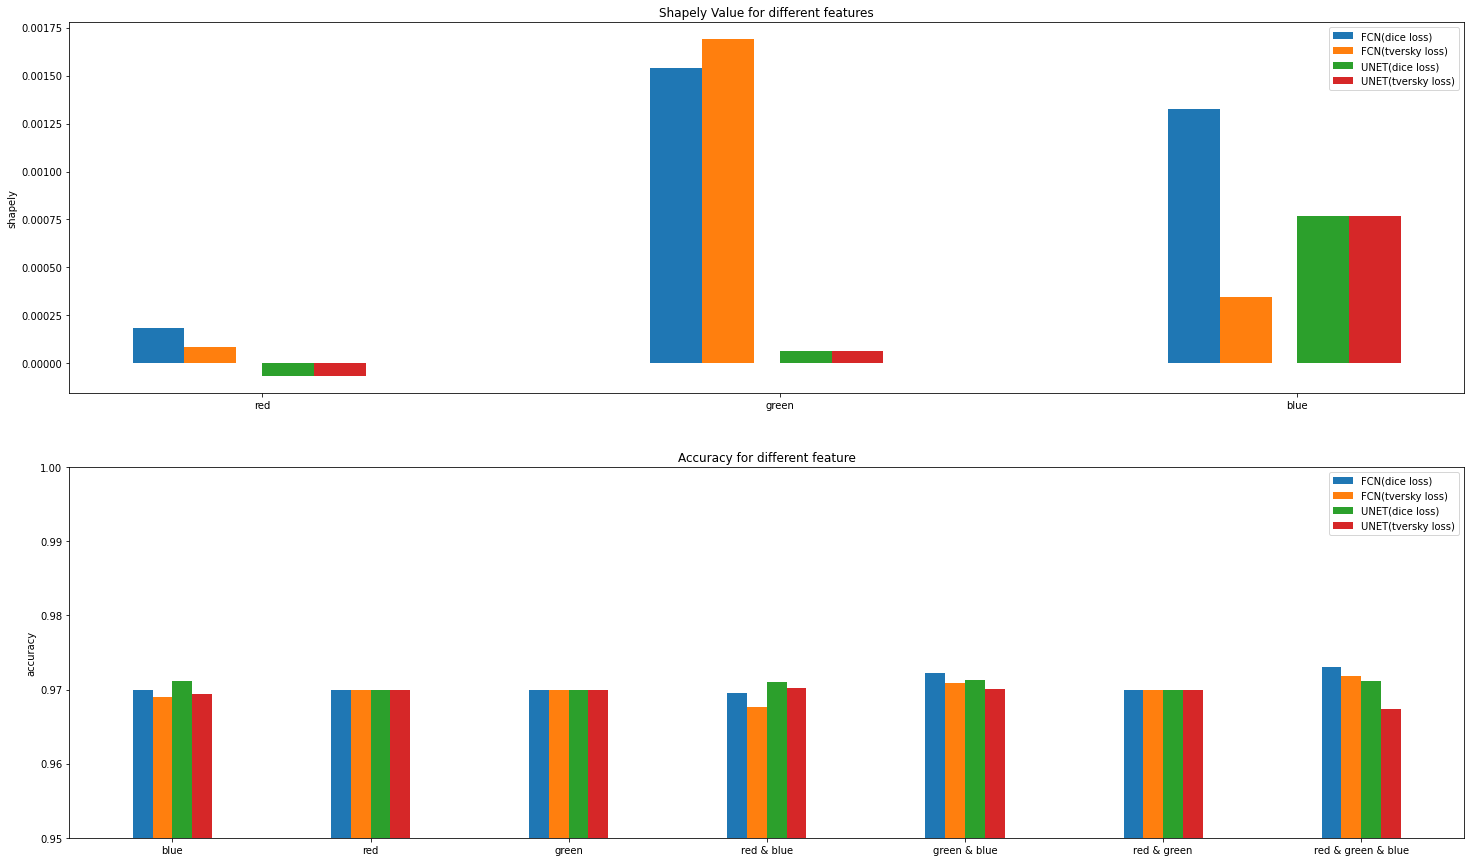

In [5]:
model_names = ['FCN(dice loss)', 'FCN(tversky loss)', 'UNET(dice loss)', 'UNET(tversky loss)']
shapely_arr = convert_map_to_arrays(shapely, feature_names, model_names)
all_features = accuracy['FCN(dice loss)'].keys()
accuracy_arr = convert_map_to_arrays(accuracy, all_features, model_names)

fig, (ax, bx) = plt.subplots(2, figsize=(25, 15))
x = np.arange(len(feature_names))

rects1 = ax.bar(x - 0.2, shapely_arr[0], width=0.1, label='FCN(dice loss)')
rects2 = ax.bar(x - 0.1, shapely_arr[1], width=0.1, label='FCN(tversky loss)')
rects3 = ax.bar(x + 0.05, shapely_arr[2], width=0.1, label='UNET(dice loss)')
rects4 = ax.bar(x + 0.15, shapely_arr[2], width=0.1, label='UNET(tversky loss)')

ax.set_ylabel('shapely')
ax.set_title('Shapely Value for different features')
ax.set_xticks(x)
ax.set_xticklabels(feature_names)
ax.legend()

y = np.arange(len(all_features))

rects5 = bx.bar(y - 0.15, accuracy_arr[0], width=0.1, label='FCN(dice loss)')
rects6 = bx.bar(y - 0.05, accuracy_arr[1], width=0.1, label='FCN(tversky loss)')
rects7 = bx.bar(y + 0.05, accuracy_arr[2], width=0.1, label='UNET(dice loss)')
rects8 = bx.bar(y + 0.15, accuracy_arr[3], width=0.1, label='UNET(tversky loss)')

bx.set_ylabel('accuracy')
bx.set_title('Accuracy for different feature')
bx.set_xticks(y)
bx.set_ylim(0.95, 1.0)
bx.set_xticklabels(all_features)
bx.legend()

2


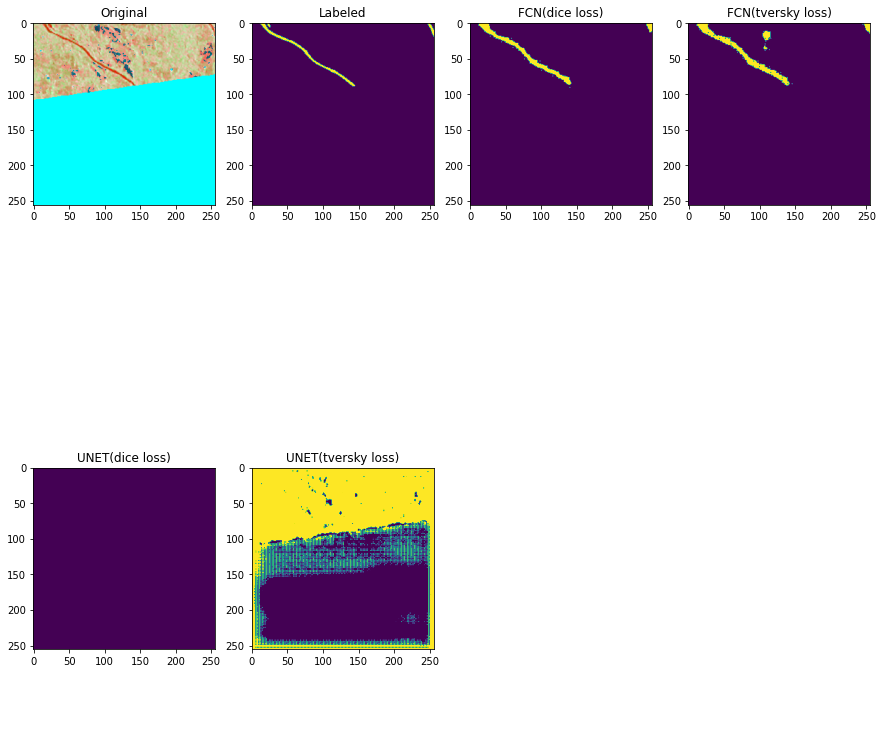

In [9]:
index = 2 # from 1 to 10 or to 100 depending on validation set
images_to_show = []
labels = []

images_to_show.append(x_validate[index])
labels.append('Original')
images_to_show.append(y_validate[index])
labels.append('Labeled')
for model in enumerate(models):
    predicted = model[1].predict(x_validate)
    images_to_show.append(predicted[index])
    labels.append(model_names[model[0]])

show_images(images_to_show, labels)